In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV


def convert_to_unix(timestamp):
    return int(pd.to_datetime(timestamp).timestamp())

#read csv
df = pd.read_csv('Significant_Earthquakes.csv')

#only using human reviewed data of type earthquake
df = df.loc[df['status'] == 'reviewed']
df = df.loc[df['type'] == 'earthquake']

#clean data
#df = df.drop({'nst', 'gap', 'dmin', 'rms', 'magType', 'net', 'id', 'updated', 'place', 'type', }, axis=1)
df = df.dropna(subset = {'mag', 'depth'})



In [7]:
df['unix-time'] = df['time'].apply(lambda x : convert_to_unix(x))
print(df['unix-time'].head(5))

16   -2074685639
17   -2074687045
18   -2067562761
19   -2067585260
20   -2061893799
Name: unix-time, dtype: int64


In [12]:
#get x, y
x = df[['latitude', 'longitude', 'depth', 'unix-time']]
y = df['mag']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=0)

for num_trees =  1
Training R-squared Score: 0.5234580564949747
Testing R-squared Score: -0.2803619491932323
for num_trees =  25
Training R-squared Score: 0.89226066519322
Testing R-squared Score: 0.2956421522386117
for num_trees =  50
Training R-squared Score: 0.8995104545902586
Testing R-squared Score: 0.3081621461603353
for num_trees =  75
Training R-squared Score: 0.9023378127508117
Testing R-squared Score: 0.3122241940783349
for num_trees =  100
Training R-squared Score: 0.9035925328790406
Testing R-squared Score: 0.31524888411674734
for num_trees =  125
Training R-squared Score: 0.9045782833690288
Testing R-squared Score: 0.31621465691825357
for num_trees =  150
Training R-squared Score: 0.9050109305188949
Testing R-squared Score: 0.3176079454622073
[-0.2803619491932323, 0.2956421522386117, 0.3081621461603353, 0.3122241940783349, 0.31524888411674734, 0.31621465691825357, 0.3176079454622073]
[1, 25, 50, 75, 100, 125, 150]


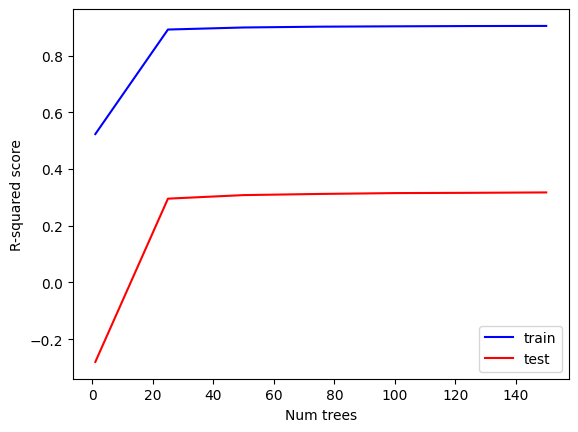

In [ ]:
#plot validation curves
num_trees = [1, 25, 50, 75, 100, 125, 150]

train_r2 = []
test_r2 = []

for n in num_trees:
    print("for num_trees = ", n)
    rf = RandomForestRegressor(n_estimators=n, random_state=0)
    rf.fit(x_train, y_train)

    y_pred = rf.predict(x_test)
    y_train_pred= rf.predict(x_train)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_pred)

    train_r2.append(r2_train)
    test_r2.append(r2_test)

    print(f"Training R-squared Score: {r2_train}")
    print(f"Testing R-squared Score: {r2_test}")


print(test_r2)
print(num_trees)


plt.plot(num_trees, train_r2, color='blue')
plt.plot(num_trees, test_r2, color = 'red')

plt.xlabel('Num trees')
plt.ylabel('R-squared score')
plt.legend(["train", "test"], loc= "lower right")

plt.show()


In [8]:
#returns dist in km between two coordinate pairs
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  #earth radius(km)
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

In [9]:
import geopandas as gpd
from shapely.geometry import Point, MultiLineString
from shapely.ops import nearest_points


#read plate data
tectonic_plates = gpd.read_file('plate-boundaries\Micro_Plates_and_Major_Fault_Zones.geojson')

tectonic_plates_multilinestring = MultiLineString(tectonic_plates.geometry.values)

#compute nearest plate boundary
def distance_to_nearest_boundary(row):
    lat = row['latitude']
    lon = row['longitude']
    
    point = Point(lon, lat)
    nearest_boundary_point = nearest_points(point, tectonic_plates_multilinestring)[1]
    
    distance = haversine_distance(lat, lon, nearest_boundary_point.y, nearest_boundary_point.x)
    return distance

#add to column df 
df['distance-to-boundary'] = df.apply(distance_to_nearest_boundary, axis=1)
print(df['distance-to-boundary'])


16       252.199038
17       264.015391
18       411.050077
19       450.786963
20        58.801930
            ...    
96170    279.993760
96171    198.277926
96172    252.474613
96173      8.948526
96174      9.871579
Name: distance-to-boundary, Length: 95296, dtype: float64


In [46]:
x = df[['latitude', 'longitude', 'depth', 'unix-time']]
y = df['mag']

In [29]:

#instantiate hyperparam values
n_estimators = [10, 50, 100]
max_depth = [10, 20, 30, 40]
min_samples_split = [5, 10, 20, 40]
min_samples_leaf = [1, 5, 10, 20]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=0)

train_r2 = []
test_r2 = [] 

max_r2_train = 0
max_r2_test = 0

best_train_params = []
best_test_params = []

#grid search
for n in n_estimators:
    for maxD in max_depth:
        for min_split in min_samples_split:
            for min_leaf in min_samples_leaf:

                print("using: n_estimators=", n, "max_depth=", maxD, "min_samples_split=", min_split, "min_samples_leaf=", min_leaf)
                rf = RandomForestRegressor(n_estimators=n, max_depth = maxD, min_samples_split = min_split, min_samples_leaf = min_leaf, random_state=0)
                rf.fit(x_train, y_train)

                y_pred = rf.predict(x_test)
                y_train_pred= rf.predict(x_train)

                r2_train = r2_score(y_train, y_train_pred)
                r2_test = r2_score(y_test, y_pred)

                train_r2.append(r2_train)
                test_r2.append(r2_test)

                print(f"Training R-squared Score: {r2_train}")
                print(f"Testing R-squared Score: {r2_test}")

                if (r2_train > max_r2_train):
                    best_train_params = [n, maxD, min_split, min_leaf]

                if (r2_test > max_r2_test):
                    best_test_params = [n, maxD, min_split, min_leaf]

print(best_train_params)
print(best_test_params)


using: n_estimators= 10 max_depth= 10 min_samples_split= 5 min_samples_leaf= 1
Training R-squared Score: 0.4049878127243045
Testing R-squared Score: 0.3375421132076829
using: n_estimators= 10 max_depth= 10 min_samples_split= 5 min_samples_leaf= 5
Training R-squared Score: 0.3966566048089041
Testing R-squared Score: 0.3394800293438589
using: n_estimators= 10 max_depth= 10 min_samples_split= 5 min_samples_leaf= 10
Training R-squared Score: 0.38876288896234223
Testing R-squared Score: 0.33982547770169524
using: n_estimators= 10 max_depth= 10 min_samples_split= 5 min_samples_leaf= 20
Training R-squared Score: 0.3789407353146589
Testing R-squared Score: 0.3396021011024959
using: n_estimators= 10 max_depth= 10 min_samples_split= 10 min_samples_leaf= 1
Training R-squared Score: 0.3999916932518347
Testing R-squared Score: 0.33877992303956694
using: n_estimators= 10 max_depth= 10 min_samples_split= 10 min_samples_leaf= 5
Training R-squared Score: 0.3966566048089041
Testing R-squared Score: 0.33

In [55]:
#get new train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

#model instance with best hyperparams
rf = RandomForestRegressor(n_estimators=best_test_params[0], max_depth = best_test_params[1], min_samples_split = best_test_params[2], min_samples_leaf = best_test_params[3])
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

r2 = r2_score(y_test, y_pred)
print(f"Final R-squared Score: {r2}")

print(train_r2)
print(test_r2)

Final R-squared Score: 0.35512505458469323
[0.4049878127243045, 0.3966566048089041, 0.38876288896234223, 0.3789407353146589, 0.3999916932518347, 0.3966566048089041, 0.38876288896234223, 0.3789407353146589, 0.39368247409115265, 0.39101328527251145, 0.38876288896234223, 0.3789407353146589, 0.3859580670108096, 0.38373585689170686, 0.3824112214477481, 0.3789407353146589, 0.7191978139218184, 0.6019917506140291, 0.5201562130338261, 0.4545365819657968, 0.6605188320385598, 0.6019917506140291, 0.5201562130338261, 0.4545365819657968, 0.5919798577662083, 0.5510746982345067, 0.5201562130338261, 0.4545365819657968, 0.5253971311655918, 0.4965358569652858, 0.47860282110363017, 0.4545365819657968, 0.8111556588876242, 0.6352555979938918, 0.5326086165340458, 0.45722001353324815, 0.7309235939843997, 0.6352555979938918, 0.5326086165340458, 0.45722001353324815, 0.6385548756631292, 0.5733013249894627, 0.5326086165340458, 0.45722001353324815, 0.55152444897638, 0.5090605084063613, 0.4860933574048314, 0.457220

Average Training R² Score: 0.46659210566296255
Average Validation R² Score: 0.35393391101009186


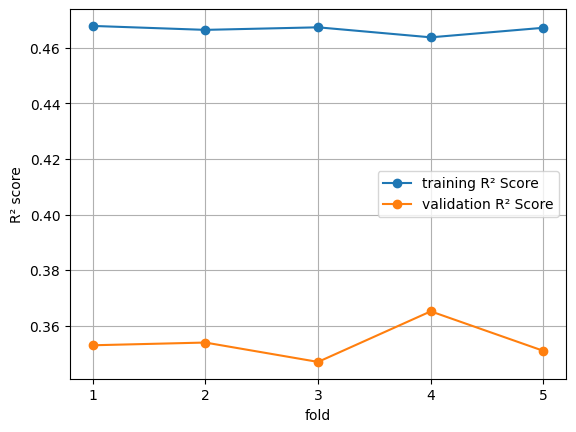

In [60]:
import numpy as np
from sklearn.model_selection import KFold

#k-fold cross-validation
k = 5 
kf = KFold(n_splits=k, shuffle=True, random_state=0)

train_r2_scores = np.zeros(k)
val_r2_scores = np.zeros(k)

for i, (train_index, val_index) in enumerate(kf.split(x)):
    #print("fold #",i)
    #split data into training/validation sets
    X_train, X_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    rf.fit(X_train, y_train)

    #training r2 score
    y_train_pred = rf.predict(X_train)
    train_r2_scores[i] = r2_score(y_train, y_train_pred)

    #validation r2 score
    y_val_pred = rf.predict(X_val)
    val_r2_scores[i] = r2_score(y_val, y_val_pred)

#avg r2 score over train/validation
avg_train_r2_score = np.mean(train_r2_scores)
avg_val_r2_score = np.mean(val_r2_scores)

print("Average Training R² Score:", avg_train_r2_score)
print("Average Validation R² Score:", avg_val_r2_score)

folds = np.arange(1, k + 1)

plt.plot(folds, train_r2_scores, marker='o', label='training R² Score')
plt.plot(folds, val_r2_scores, marker='o', label='validation R² Score')

plt.xlabel('fold')
plt.ylabel('R² score')
plt.xticks(folds)
plt.legend()
plt.grid()

# Display the plot
plt.show()


